# Import library

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/abiyamf/miniconda3/envs/myenv/lib/python3.9/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [2]:
import time
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

2024-10-25 00:48:02.178896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 00:48:02.216685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 00:48:02.228121: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 00:48:02.281840: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 00:48:04.127275: W tensorflow/compiler/tf2

In [3]:
# Cek apakah ada GPU yang tersedia
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"TensorFlow mendeteksi {len(gpus)} GPU:")
    for gpu in gpus:
        print(gpu)
else:
    print("TensorFlow tidak mendeteksi GPU.")

TensorFlow mendeteksi 1 GPU:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1729792085.246394    2624 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729792085.308522    2624 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729792085.308624    2624 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.


# Define Fungsi

In [4]:
def model_parameter():
    # Membuat dictionary untuk menyimpan informasi jumlah parameter
    model_info = {
        'Model': ['EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7'],
        'Total Parameters': []
    }
    
    # Menghitung jumlah parameter dari setiap model EfficientNet
    models = [EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7]
    for model in models:
        model_instance = model(weights=None)  # Membuat instance dari model tanpa bobot pre-trained
        total_params = model_instance.count_params()  # Menghitung jumlah parameter
        model_info['Total Parameters'].append(total_params)
    
    # Membuat DataFrame dari dictionary
    df = pd.DataFrame(model_info)
    
    # Menambahkan pemisah ribuan (titik)
    df['Total Parameters'] = df['Total Parameters'].apply(lambda x: f"{x:,}".replace(",", "."))
    return df

In [5]:
def augment_and_resize_dataset(base_path, img_size, batch_size, preprocess_input_func=None):
    train_path = os.path.join(base_path, 'train')
    validation_path = os.path.join(base_path, 'val')
    test_path = os.path.join(base_path, 'test')

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_func,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Untuk data validation dan test, hanya preprocessing
    validation_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_func)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_generator = validation_test_datagen.flow_from_directory(
        validation_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = validation_test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [6]:
def build_and_compile_model_not_trainable(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
def build_and_compile_model_trainable(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = True

    # Freeze 50% layer pertama dari base model
    total_layers = len(base_model.layers)
    freeze_layers = int(0.50 * total_layers)
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)


    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [8]:
def build_and_compile_model_trainable_None(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights=None)
    base_model.trainable = True

    inputs = Input(shape=input_shape)
    
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def build_and_compile_model_trainable_None_modifikasi(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights=None)
    base_model.trainable = True

    inputs = Input(shape=input_shape)
    
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
# Fungsi untuk melatih model dan menampilkan grafik serta menyimpannya
def train_and_plot(model, model_name, train_generator, validation_generator, test_generator, epochs, save_directory):
    # Membuat folder penyimpanan jika belum ada
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # Membuat folder untuk menyimpan gambar
    images_save_directory = os.path.join(save_directory, 'images')
    if not os.path.exists(images_save_directory):
        os.makedirs(images_save_directory)

    # Menyusun nama file penyimpanan model dengan parameter model_name
    save_path = os.path.join(save_directory, f'best_model_{model_name}.keras')

    # Callback untuk menyimpan model terbaik berdasarkan akurasi pada data validasi
    checkpoint_callback = ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, mode='max')

    # Callback untuk menghentikan pelatihan jika tidak ada perbaikan setelah beberapa epoch
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Menghitung waktu mulai pelatihan
    start_time = time.time()
    
    # Melatih model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[checkpoint_callback]
    )
    
    # Menghitung waktu selesai pelatihan
    end_time = time.time()
    
    # Menghitung durasi pelatihan
    training_duration = end_time - start_time  # dalam detik

    # Plotting hasil akurasi
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Save the loss plot
    plt.savefig(os.path.join(images_save_directory, f'{model_name}_accuracy_loss.png'))

    # Tampilkan plot
    plt.show()

    # Evaluasi model pada data test
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Prediksi pada data test
    y_pred = model.predict(test_generator)

    # Mengambil index dari prediksi (kelas dengan probabilitas tertinggi)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Mengambil label sebenarnya dari generator
    y_true = test_generator.classes

    # Membuat confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    class_names = list(test_generator.class_indices.keys())

    # Menampilkan classification report
    print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

    # Plot confusion matrix sebagai heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save the confusion matrix plot
    plt.savefig(os.path.join(images_save_directory, f'{model_name}_confusion_matrix.png'))

    # Tampilkan confusion matrix
    plt.close()
    # plt.show()

    return history, test_loss, test_accuracy, training_duration


In [10]:
import os
import pandas as pd

def store_results(title, model, history, test_loss, test_accuracy, training_duration, csv_filename, img_size, batch_size, total_params, GPU_NAME, train_generator=None, validation_generator=None, test_generator=None):
    # Mengubah durasi training dari detik ke jam
    training_duration_hours = training_duration / 3600

    # Menyimpan akurasi dan loss tertinggi dari history untuk training dan validation
    max_train_acc = max(history.history['accuracy']) if 'accuracy' in history.history else None
    max_val_acc = max(history.history['val_accuracy']) if 'val_accuracy' in history.history else None

    # Menghitung jumlah gambar dari generator
    num_train_images = train_generator.samples if train_generator else None
    num_val_images = validation_generator.samples if validation_generator else None
    num_test_images = test_generator.samples if test_generator else None

    # Menyusun data untuk disimpan ke CSV dengan total_params yang diformat dengan titik
    data = {
        'GPU': [GPU_NAME],
        'Title': [title],
        'Model': [model_name],  # Anda juga dapat menyimpan nama model
        'Total Parameters': [f"{total_params:,}".replace(",", ".")],  # Jumlah parameter model dengan titik pemisah ribuan
        'Image Size': [img_size],
        'Batch Size': [batch_size],
        'Train Images': [num_train_images],
        'Validation Images': [num_val_images],
        'Test Images': [num_test_images],
        'Train Accuracy': [max_train_acc],
        'Train Loss': [min(history.history['loss']) if 'loss' in history.history else None],
        'Validation Accuracy': [max_val_acc],
        'Validation Loss': [min(history.history['val_loss']) if 'val_loss' in history.history else None],
        'Test Accuracy': [test_accuracy],
        'Test Loss': [test_loss],
        'Training Duration (seconds)': [training_duration],
        'Training Duration (hours)': [training_duration_hours],
        'Total Epoch': [max(history.epoch)],
    }

    # Membuat DataFrame dari data yang akan disimpan
    results_df = pd.DataFrame(data)

    # Cek apakah file sudah ada, jika tidak, buat file baru
    file_exists = os.path.isfile(csv_filename)

    # Append ke file CSV, mode 'w' jika file belum ada, 'a' untuk append jika file ada
    results_df.to_csv(csv_filename, mode='a' if file_exists else 'w', header=not file_exists, index=False)

In [11]:
efficientnet_input_shapes = {
    'EfficientNetB0': (224, 224),
    'EfficientNetB1': (240, 240),
    'EfficientNetB2': (260, 260),
    'EfficientNetB3': (300, 300),
    'EfficientNetB4': (380, 380),
    'EfficientNetB5': (456, 456),
    'EfficientNetB6': (528, 528),
    'EfficientNetB7': (600, 600),
}

base_path = "data/split_train_test_dataset_campuran"

preprocess_input_func = efficientnet_preprocess

## Variabel Global

In [12]:
epochs = 100
batch_size = 32
save_directory = 'best_model_modifikasi/'
csv_filename = 'outputs/modifikasi.csv'
GPU_NAME = "A100 40GB"

# EfficientNet Original

## Source code 

In [13]:
from utils.efficientNet import *
model_parameter()

I0000 00:00:1729792111.674581    2624 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729792111.674737    2624 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729792111.674807    2624 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729792111.958419    2624 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729792111.958536    2624 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-25

,Model,Total Parameters
0,EfficientNetB0,5.330.571
1,EfficientNetB1,7.856.239
2,EfficientNetB2,9.177.569
3,EfficientNetB3,12.320.535
4,EfficientNetB4,19.466.823
5,EfficientNetB5,30.562.527
6,EfficientNetB6,43.265.143
7,EfficientNetB7,66.658.687


## Training menggunakan EfficientNet Not Modified Not Trainable Weights imagenet

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/2


2024-10-25 00:51:45.639668: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-25 00:51:46.165343: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
I0000 00:00:1729792333.453164    2683 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4553 - loss: 1.0074

2024-10-25 00:54:12.087769: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-25 00:54:12.587235: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


44/44 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.4575 - loss: 1.0053 - val_accuracy: 0.6552 - val_loss: 0.7112
Epoch 2/2
44/44 ━━━━━━━━━━━━━━━━━━━━ 43s 973ms/step - accuracy: 0.7064 - loss: 0.6880 - val_accuracy: 0.7816 - val_loss: 0.5153


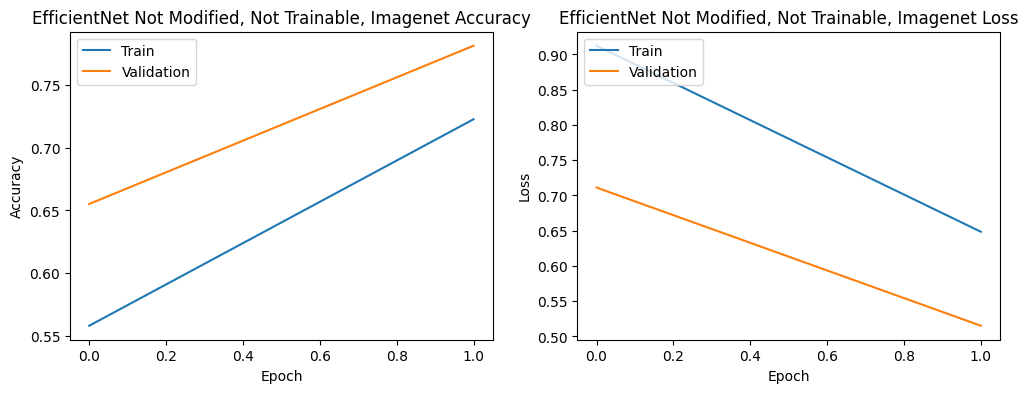

79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.3255 - loss: 1.2981

2024-10-25 00:55:46.974920: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-25 00:55:47.423145: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


80/80 ━━━━━━━━━━━━━━━━━━━━ 47s 617ms/step - accuracy: 0.3285 - loss: 1.2926
Test Accuracy: 0.4502
80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 575ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.94      0.30      0.45      1645
        rust       0.55      0.50      0.52       275
        scab       0.29      0.83      0.43       630

    accuracy                           0.45      2550
   macro avg       0.59      0.54      0.47      2550
weighted avg       0.74      0.45      0.45      2550



In [15]:
model_name = 'EfficientNetB7'
title = "EfficientNet Not Modified, Not Trainable, Imagenet"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_not_trainable(EfficientNetB7, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

## Training menggunakan EfficientNet Not Modified 50% Freeze Weights imagenet

In [ ]:
model_name = 'EfficientNetB7'
title = "EfficientNet Not Modified, 50% Freeze, Imagenet"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable(EfficientNetB7, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

## Training menggunakan EfficientNet Not Modified 0% Freeze Weights None

In [ ]:
model_name = 'EfficientNetB7'
title = "EfficientNet Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None(EfficientNetB7, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

## Training menggunakan EfficientNet Not Modified 0% Freeze Weights None (B0-B7)

In [ ]:
model_name = 'EfficientNetB0'
title = f"{model_name} Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB0, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

In [ ]:
model_name = 'EfficientNetB1'
title = f"{model_name} Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB1, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

In [ ]:
model_name = 'EfficientNetB2'
title = f"{model_name} Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB2, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

In [ ]:
model_name = 'EfficientNetB3'
title = f"{model_name} Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB3, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

In [ ]:
model_name = 'EfficientNetB4'
title = f"{model_name} Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB4, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

In [ ]:
model_name = 'EfficientNetB5'
title = f"{model_name} Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB5, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

In [ ]:
model_name = 'EfficientNetB6'
title = f"{model_name} Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB6, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

In [ ]:
model_name = 'EfficientNetB7'
title = f"{model_name} Not Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB7, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

# EfficientNet Modified

## Source Code

In [18]:
from utils.efficientNetModifikasi import *
model_parameter()

,Model,Total Parameters
0,EfficientNetB0,2.606.035
1,EfficientNetB1,4.327.275
2,EfficientNetB2,5.079.523
3,EfficientNetB3,6.063.891
4,EfficientNetB4,8.185.055
5,EfficientNetB5,14.690.923
6,EfficientNetB6,18.689.351
7,EfficientNetB7,29.953.319


## Training menggunakan EfficientNet Modified (B0-B7)

In [ ]:
model_name = 'EfficientNetB0'
title = f"{model_name} Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB0, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

In [ ]:
model_name = 'EfficientNetB1'
title = f"{model_name} Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB1, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

In [ ]:
model_name = 'EfficientNetB2'
title = f"{model_name} Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB2, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

In [ ]:
model_name = 'EfficientNetB3'
title = f"{model_name} Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB3, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

In [ ]:
model_name = 'EfficientNetB4'
title = f"{model_name} Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB4, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

In [ ]:
model_name = 'EfficientNetB5'
title = f"{model_name} Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB5, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

In [ ]:
model_name = 'EfficientNetB6'
title = f"{model_name} Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB6, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

In [ ]:
model_name = 'EfficientNetB7'
title = f"{model_name} Modified, 0% Freeze, None"

img_size = efficientnet_input_shapes[model_name]
input_shape = (*img_size, 3)

train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    base_path,
    img_size=img_size,
    batch_size=batch_size,
    preprocess_input_func=preprocess_input_func
)

model = build_and_compile_model_trainable_None_modifikasi(EfficientNetB7, input_shape=input_shape, num_classes=train_generator.num_classes)
history_model, test_loss, test_acc, training_duration = train_and_plot(model, title, train_generator, validation_generator, test_generator, epochs = epochs, save_directory=save_directory)
store_results(title, model_name, history_model, test_loss, test_acc, training_duration,csv_filename, img_size, batch_size, model.count_params(),GPU_NAME)

### Training menggunakan best model EfficientNet modified img size 224 - 600

In [ ]:
#ISI DISINI

# KFold (menggunakan best model img size)

In [ ]:
# train_generator, validation_generator, test_generator = augment_and_resize_dataset(
#     "data/split_train_test_dataset_campuran",
#     img_size=(600, 600),
#     batch_size=16,
#     preprocess_input_func = efficientnet_preprocess
# )

In [ ]:
# import numpy as np

# # Ekstrak seluruh data dan label dari generator
# def extract_images_labels(generator):
#     images = []
#     labels = []
#     for _ in range(len(generator)):  # Iterasi untuk setiap batch
#         img_batch, label_batch = next(generator)
#         images.append(img_batch)
#         labels.append(label_batch)
    
#     # Menggabungkan list menjadi array numpy
#     images = np.concatenate(images)
#     labels = np.concatenate(labels)
    
#     return images, labels

# # Ekstrak data dari train_generator
# train_images, train_labels = extract_images_labels(train_generator)


In [ ]:
# from sklearn.model_selection import KFold
# import numpy as np

# # Assuming you have train data and labels loaded, e.g., train_images, train_labels
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# fold_no = 1

# # Inisialisasi variabel untuk menyimpan hasil
# acc_per_fold = []
# loss_per_fold = []

# # K-Fold Cross Validation model evaluation
# for train_index, val_index in kfold.split(train_images, train_labels):
#     print(f'Training for fold {fold_no} ...')

#     # Split data into training and validation sets for the current fold
#     x_train_fold = train_images[train_index]
#     y_train_fold = train_labels[train_index]
#     x_val_fold = train_images[val_index]
#     y_val_fold = train_labels[val_index]

#     # Create model for this fold
#     model = EfficientNetB1(input_shape=(600, 600, 3), include_top=False, weights=None)
#     model.trainable = True
    
#     inputs = Input(shape=(600, 600, 3))
#     x = model(inputs, training=False)
#     x = GlobalAveragePooling2D()(x)
#     x = BatchNormalization()(x)
#     x = Dense(256, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.2)(x)
#     x = Dense(128, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.2)(x)
#     outputs = Dense(3, activation='softmax')(x)
#     model = Model(inputs, outputs)

#     # Compile the model
#     optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#     # Train the model for this fold
#     history = model.fit(x_train_fold, y_train_fold,
#                         epochs=50,
#                         batch_size=16,
#                         validation_data=(x_val_fold, y_val_fold))

#     # Mengevaluasi model di data validasi
#     scores = model.evaluate(x_val_fold, y_val_fold, verbose=0)
#     print(f"Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%")
#     acc_per_fold.append(scores[1] * 100)
#     loss_per_fold.append(scores[0])

#     fold_no += 1

# # Menampilkan hasil akhir dari cross-validation
# print('Average scores for all folds:')
# print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
# print(f'> Loss: {np.mean(loss_per_fold)}')

# ARCHIVE

### B0 GTX 1660 Ti

In [15]:
model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(224, 224, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3604 - loss: 1.1083 - val_accuracy: 0.3420 - val_loss: 1.0969
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 599ms/step - accuracy: 0.3913 - loss: 1.0902 - val_accuracy: 0.3420 - val_loss: 1.1001
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 538ms/step - accuracy: 0.4337 - loss: 1.0748 - val_accuracy: 0.3420 - val_loss: 1.1069
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 577ms/step - accuracy: 0.4195 - loss: 1.0688 - val_accuracy: 0.3420 - val_loss: 1.1115
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 547ms/step - accuracy: 0.4335 - loss: 1.0849 - val_accuracy: 0.3420 - val_loss: 1.1194
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 532ms/step - accuracy: 0.3982 - loss: 1.0795 - val_accuracy: 0.3420 - val_loss: 1.1261
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 538ms/step - accuracy: 0.3969 - loss: 1.0697 - val_accuracy: 0.3420 - val_loss: 1.1246
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 541ms/step - accuracy: 0.4297 - loss: 1.0593 - val

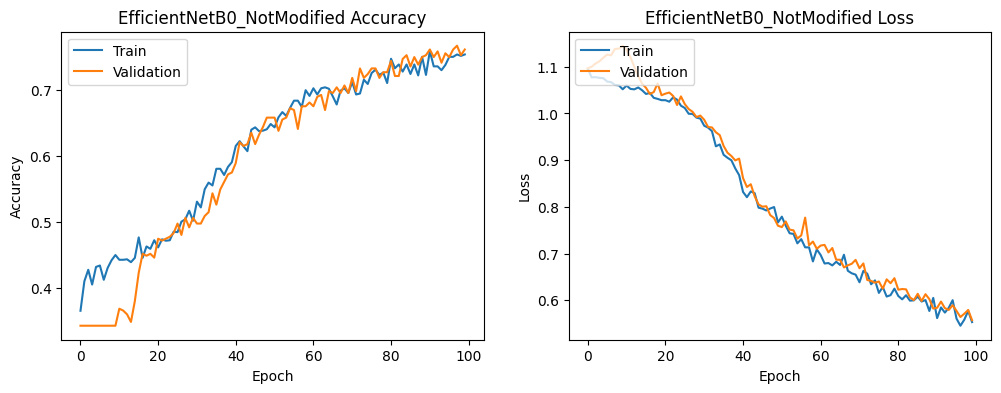

80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.8287 - loss: 0.6700
Test Accuracy: 0.6549
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.77      0.87      0.82      1645
        rust       0.34      0.16      0.21       275
        scab       0.34      0.30      0.32       630

    accuracy                           0.65      2550
   macro avg       0.48      0.44      0.45      2550
weighted avg       0.62      0.65      0.63      2550



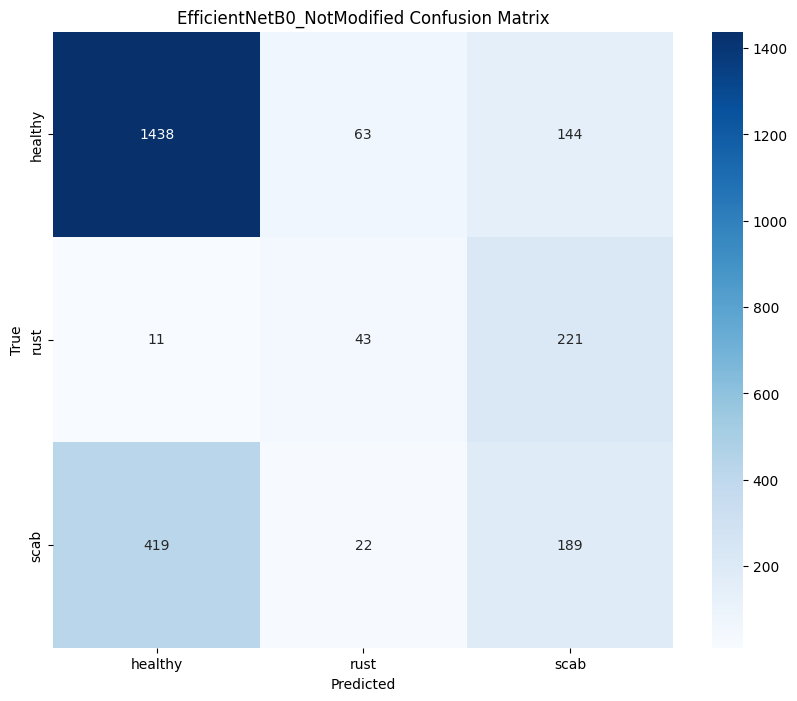

In [16]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(224, 224),
    batch_size=32,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 100
train_and_plot(model, "EfficientNetB0_NotModified", train_generator, validation_generator, test_generator, epochs =  epochs)

In [7]:
model = EfficientNetB2(input_shape=(260, 260, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(260, 260, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1729658922.538884    6949 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729658922.539021    6949 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729658922.539071    6949 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729658923.092933    6949 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729658923.093112    6949 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-23

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/100


E0000 00:00:1729659194.722463    7033 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729659194.859150    7033 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-23 11:53:23.497346: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=2} for conv (f32[528,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,528,17,17]{3,2,1,0}, f32[8,528,17,17]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=528, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a whi

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.3865 - loss: 1.0880

E0000 00:00:1729659266.506627    7032 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729659266.642579    7032 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729659266.779486    7032 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729659266.913482    7032 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729659267.089201    7032 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

173/173 ━━━━━━━━━━━━━━━━━━━━ 85s 237ms/step - accuracy: 0.3866 - loss: 1.0880 - val_accuracy: 0.3420 - val_loss: 1.1161
Epoch 2/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - accuracy: 0.4017 - loss: 1.0808 - val_accuracy: 0.3420 - val_loss: 1.1472
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 161ms/step - accuracy: 0.4253 - loss: 1.0684 - val_accuracy: 0.3621 - val_loss: 1.1147
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.3988 - loss: 1.0734 - val_accuracy: 0.4368 - val_loss: 1.0680
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.4126 - loss: 1.0650 - val_accuracy: 0.4655 - val_loss: 1.0523
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.4424 - loss: 1.0537 - val_accuracy: 0.4770 - val_loss: 1.0509
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.4489 - loss: 1.0605 - val_accuracy: 0.4741 - val_loss: 1.0697
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.4350 - loss: 1.053

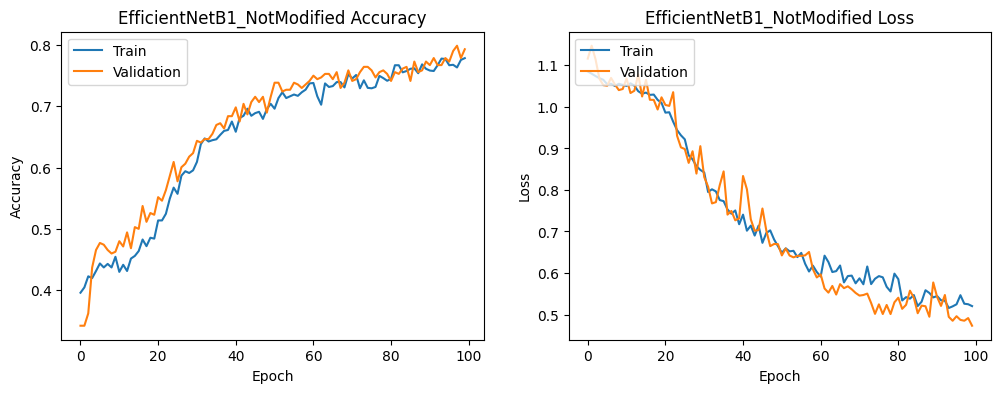

319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8266 - loss: 0.6020
Test Accuracy: 0.6471
319/319 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.76      0.87      0.81      1645
        rust       0.91      0.12      0.21       275
        scab       0.31      0.31      0.31       630

    accuracy                           0.65      2550
   macro avg       0.66      0.43      0.44      2550
weighted avg       0.66      0.65      0.62      2550



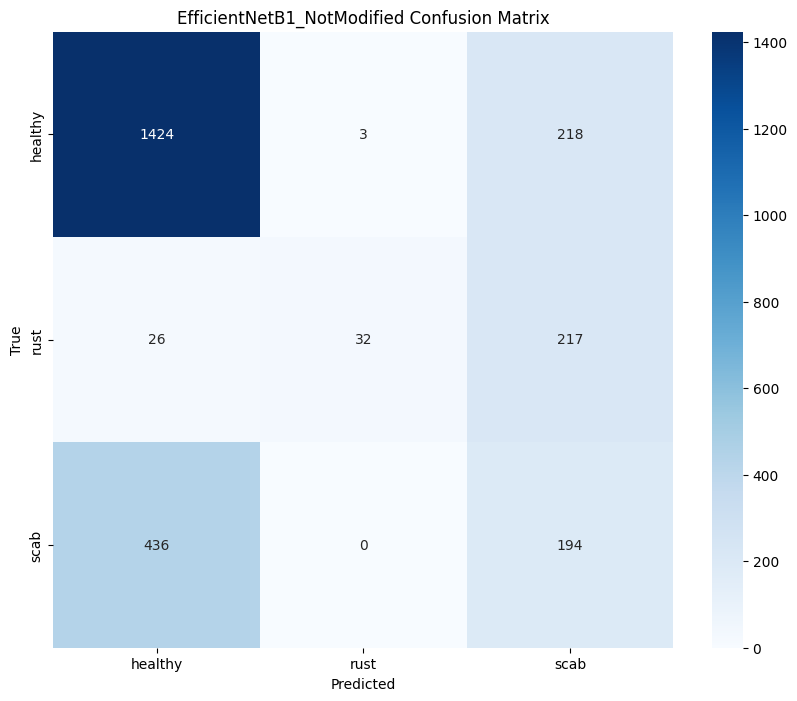

In [9]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(260, 260),
    batch_size=8,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 100
train_and_plot(model, "EfficientNetB1_NotModified", train_generator, validation_generator, test_generator, epochs =  epochs)

In [7]:
model = EfficientNetB3(input_shape=(260, 260, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(260, 260, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1729662451.870955   11508 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729662451.871094   11508 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729662451.871146   11508 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729662452.754241   11508 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729662452.754362   11508 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-23

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200


I0000 00:00:1729662481.571014   11594 service.cc:146] XLA service 0x7f7900002be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729662481.571095   11594 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-23 12:48:02.388507: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-23 12:48:05.612672: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1729662491.217154   11594 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729662491.362160   11594 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight System

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.3952 - loss: 1.0827

E0000 00:00:1729662552.392563   11594 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729662552.539380   11594 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-23 12:49:14.953576: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-23 12:49:15.065619: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more mem

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.3964 - loss: 1.0837

E0000 00:00:1729662610.802106   11596 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729662610.940417   11596 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


173/173 ━━━━━━━━━━━━━━━━━━━━ 160s 500ms/step - accuracy: 0.3963 - loss: 1.0837 - val_accuracy: 0.3420 - val_loss: 1.1119
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.3789 - loss: 1.0902 - val_accuracy: 0.3420 - val_loss: 1.1099
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.4072 - loss: 1.0767 - val_accuracy: 0.3506 - val_loss: 1.1352
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 160ms/step - accuracy: 0.4014 - loss: 1.0721 - val_accuracy: 0.4052 - val_loss: 1.0663
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.4337 - loss: 1.0627 - val_accuracy: 0.4109 - val_loss: 1.0962
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.4675 - loss: 1.0454 - val_accuracy: 0.4282 - val_loss: 1.1483
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 161ms/step - accuracy: 0.4384 - loss: 1.0500 - val_accuracy: 0.4310 - val_loss: 1.2718
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.3995 - loss: 1.08

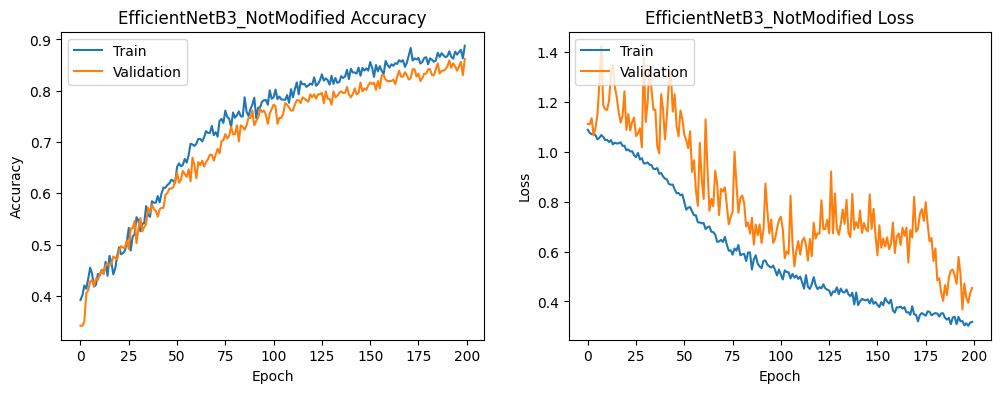

319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7072 - loss: 0.9269
Test Accuracy: 0.5671
319/319 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.73      0.74      0.73      1645
        rust       0.21      0.24      0.22       275
        scab       0.29      0.25      0.27       630

    accuracy                           0.57      2550
   macro avg       0.41      0.41      0.41      2550
weighted avg       0.56      0.57      0.56      2550



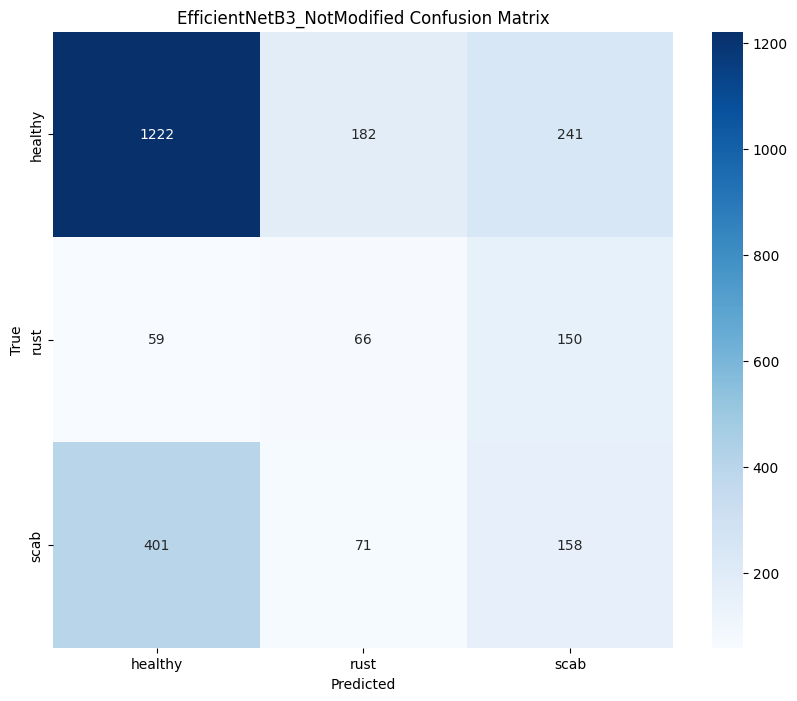

In [8]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(260, 260),
    batch_size=8,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 200
train_and_plot(model, "EfficientNetB3_NotModified", train_generator, validation_generator, test_generator, epochs =  epochs)

In [7]:
model = EfficientNetB7(input_shape=(300, 300, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(300, 300, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1729675758.068755   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729675758.068886   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729675758.068931   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729675759.911081   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729675759.911216   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-23

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 19, 19, 2560)   │    27,392,319 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,622,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,541,122 (116.51 MB)

 Trainable params: 30,413,051 (116.02 MB)

 Non-trainable params: 128,071 (500.28 KB)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1729675816.936303   23452 service.cc:146] XLA service 0x7f9db40020a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729675816.936384   23452 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-23 16:30:18.716247: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-23 16:30:25.908496: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1729675841.255858   23452 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729675841.389734   23452 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight System

188/346 ━━━━━━━━━━━━━━━━━━━━ 28s 180ms/step - accuracy: 0.3931 - loss: 1.1030

E0000 00:00:1729675948.631973   23456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729675948.770451   23456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729675948.906702   23456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729675949.044441   23456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729675949.183319   23456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

346/346 ━━━━━━━━━━━━━━━━━━━━ 279s 422ms/step - accuracy: 0.3971 - loss: 1.0992 - val_accuracy: 0.3420 - val_loss: 1.1344
Epoch 2/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 67s 194ms/step - accuracy: 0.3846 - loss: 1.0898 - val_accuracy: 0.3851 - val_loss: 1.8298
Epoch 3/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 195ms/step - accuracy: 0.4233 - loss: 1.0770 - val_accuracy: 0.4368 - val_loss: 3.9750
Epoch 4/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 196ms/step - accuracy: 0.4299 - loss: 1.0747 - val_accuracy: 0.3736 - val_loss: 3.3302
Epoch 5/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 197ms/step - accuracy: 0.3808 - loss: 1.0962 - val_accuracy: 0.4023 - val_loss: 2.5894
Epoch 6/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 196ms/step - accuracy: 0.4307 - loss: 1.0695 - val_accuracy: 0.4195 - val_loss: 4.1685
Epoch 7/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 197ms/step - accuracy: 0.4002 - loss: 1.0825 - val_accuracy: 0.4454 - val_loss: 2.2188
Epoch 8/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 69s 199ms/step - accuracy: 0.3996 - loss: 1.06

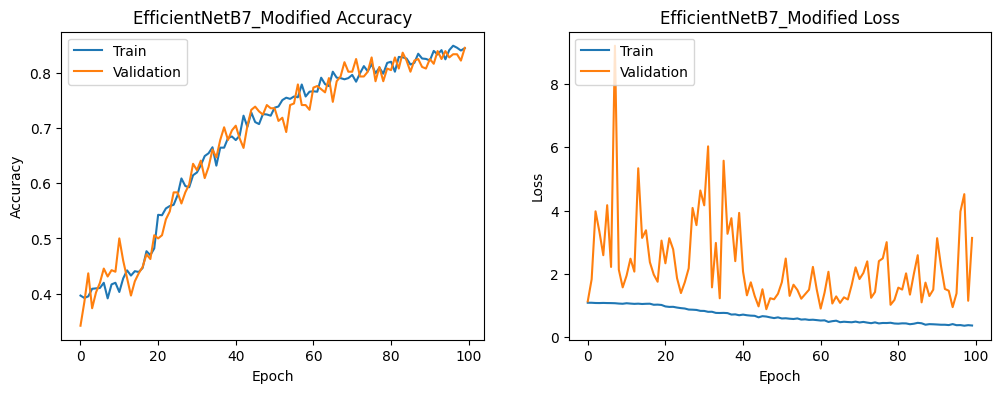

638/638 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.7539 - loss: 6.7549
Test Accuracy: 0.6039
638/638 ━━━━━━━━━━━━━━━━━━━━ 51s 64ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.75      0.80      0.77      1645
        rust       0.15      0.22      0.18       275
        scab       0.41      0.27      0.32       630

    accuracy                           0.60      2550
   macro avg       0.44      0.43      0.43      2550
weighted avg       0.60      0.60      0.60      2550



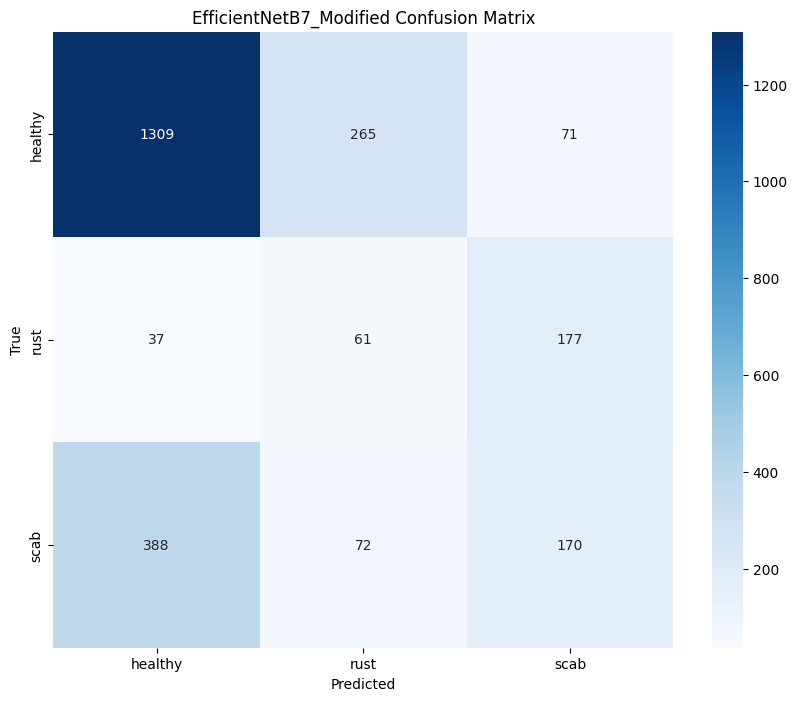

In [8]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(300, 300),
    batch_size=4,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 100
train_and_plot(model, "EfficientNetB7_Modified", train_generator, validation_generator, test_generator, epochs =  epochs)

In [12]:
# Fungsi untuk melatih model dan menampilkan grafik serta menyimpannya
def train_and_plot_and_saved(model, model_name, train_generator, validation_generator, test_generator, epochs):
    # Callback untuk menghentikan pelatihan jika tidak ada perbaikan setelah beberapa epoch
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Melatih model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs
        # callbacks=[early_stopping_callback]
    )

    model.save('ENB7_MODIFIED_200EPOCHS.keras')

    # Plotting hasil akurasi
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Tampilkan plot
    plt.show()

    # Evaluasi model pada data test
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Prediksi pada data test
    y_pred = model.predict(test_generator)

    # Mengambil index dari prediksi (kelas dengan probabilitas tertinggi)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Mengambil label sebenarnya dari generator
    y_true = test_generator.classes

    # Membuat confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    class_names = list(test_generator.class_indices.keys())

    # Menampilkan classification report
    print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

    # Plot confusion matrix sebagai heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Tampilkan confusion matrix
    plt.show()

In [13]:
model = EfficientNetB7(input_shape=(300, 300, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(300, 300, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2024-10-24 11:23:21.643573: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14936 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:4e:00.0, compute capability: 8.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 19, 19, 2560)   │    27,392,319 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,622,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,541,122 (116.51 MB)

 Trainable params: 30,413,051 (116.02 MB)

 Non-trainable params: 128,071 (500.28 KB)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/250
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 194ms/step - accuracy: 0.3943 - loss: 1.0891 - val_accuracy: 0.4368 - val_loss: 1.5727
Epoch 2/250
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 196ms/step - accuracy: 0.4047 - loss: 1.0890 - val_accuracy: 0.4224 - val_loss: 2.3367
Epoch 3/250
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 197ms/step - accuracy: 0.3949 - loss: 1.0831 - val_accuracy: 0.4282 - val_loss: 3.5399
Epoch 4/250
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 197ms/step - accuracy: 0.4178 - loss: 1.0721 - val_accuracy: 0.4282 - val_loss: 2.1141
Epoch 5/250
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 198ms/step - accuracy: 0.4149 - loss: 1.0797 - val_accuracy: 0.4253 - val_loss: 2.2503
Epoch 6/250
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 197ms/step - accuracy: 0.4250 - loss: 1.0606 - val_accuracy: 0.4828 - val_loss: 1.2056
Epoch 7/250
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 198ms/step - accuracy: 0.4323 - loss: 1.0587 - val_accuracy: 0.4483 - val_loss: 2.3049
Epoch 8/250
346/346 ━━━━━━━━━━━━━━━━━━━━ 82s 196ms/step - accuracy: 0.4446 -

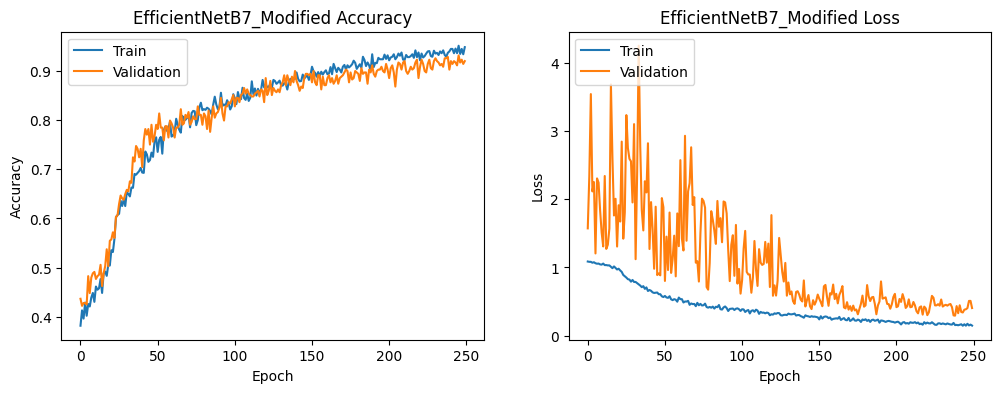

638/638 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.9278 - loss: 0.7204
Test Accuracy: 0.7949
638/638 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.87      0.97      0.91      1645
        rust       0.47      0.13      0.20       275
        scab       0.63      0.64      0.63       630

    accuracy                           0.79      2550
   macro avg       0.65      0.58      0.58      2550
weighted avg       0.76      0.79      0.77      2550



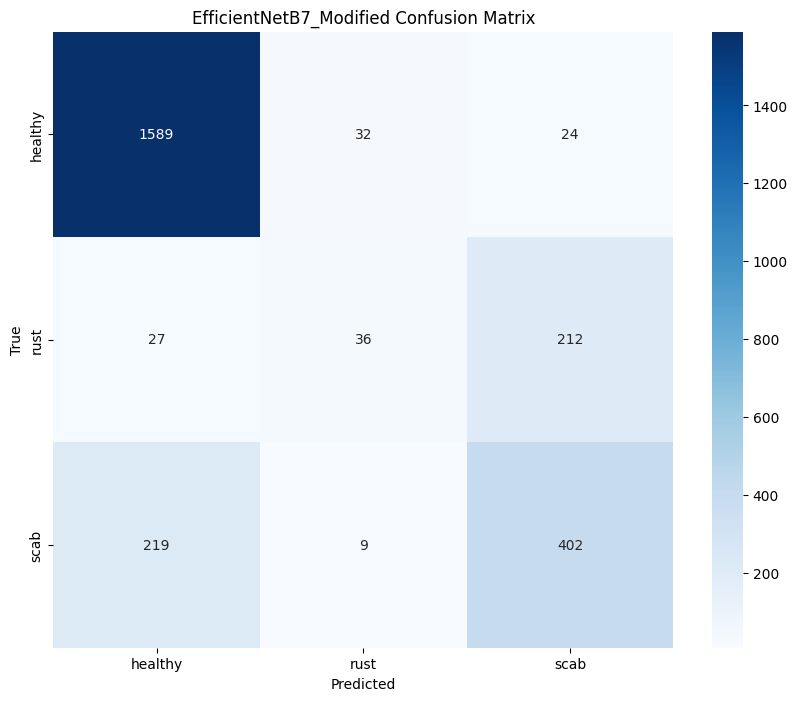

In [13]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(300, 300),
    batch_size=4,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 250
train_and_plot_and_saved(model, "EfficientNetB7_Modified", train_generator, validation_generator, test_generator, epochs =  epochs)

In [8]:
model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
model.trainable = True

inputs = Input(shape=(224, 224, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1729671865.254654   21093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729671865.254773   21093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729671865.254842   21093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729671866.588226   21093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729671866.588309   21093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-23

ValueError: Layer count mismatch when loading weights from file. Model expected 75 layers, found 131 saved layers.

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 759ms/step - accuracy: 0.3001 - loss: 1.7218 - val_accuracy: 0.3592 - val_loss: 1.1188
Epoch 2/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.4284 - loss: 1.3337 - val_accuracy: 0.4368 - val_loss: 1.0658
Epoch 3/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.4505 - loss: 1.3179 - val_accuracy: 0.5431 - val_loss: 0.9671
Epoch 4/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 285ms/step - accuracy: 0.5163 - loss: 1.1420 - val_accuracy: 0.6149 - val_loss: 0.8798
Epoch 5/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 295ms/step - accuracy: 0.5487 - loss: 1.0815 - val_accuracy: 0.6408 - val_loss: 0.8048
Epoch 6/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 276ms/step - accuracy: 0.5630 - loss: 0.9987 - val_accuracy: 0.6868 - val_loss: 0.7241
Epoch 7/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 277ms/step - accuracy: 0.6312 - loss: 0.8638 - val_accurac

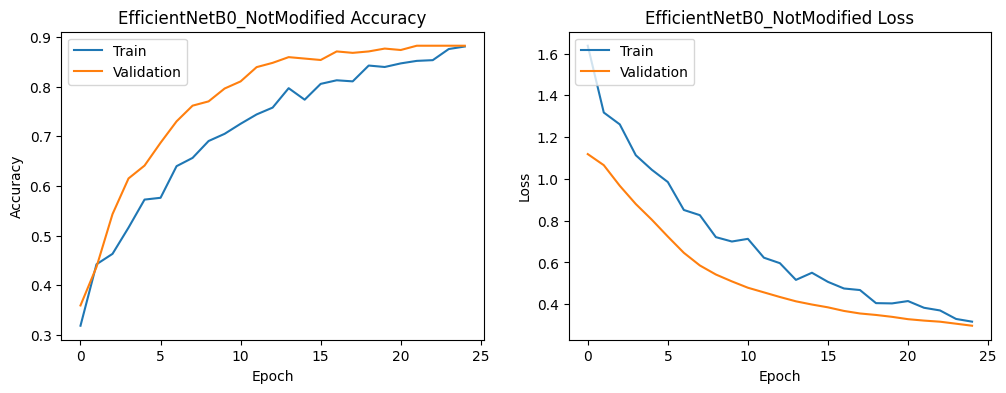

160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.5746 - loss: 1.0900
Test Accuracy: 0.5875
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.88      0.59      0.71      1645
        rust       0.85      0.11      0.19       275
        scab       0.35      0.80      0.49       630

    accuracy                           0.59      2550
   macro avg       0.70      0.50      0.46      2550
weighted avg       0.75      0.59      0.60      2550



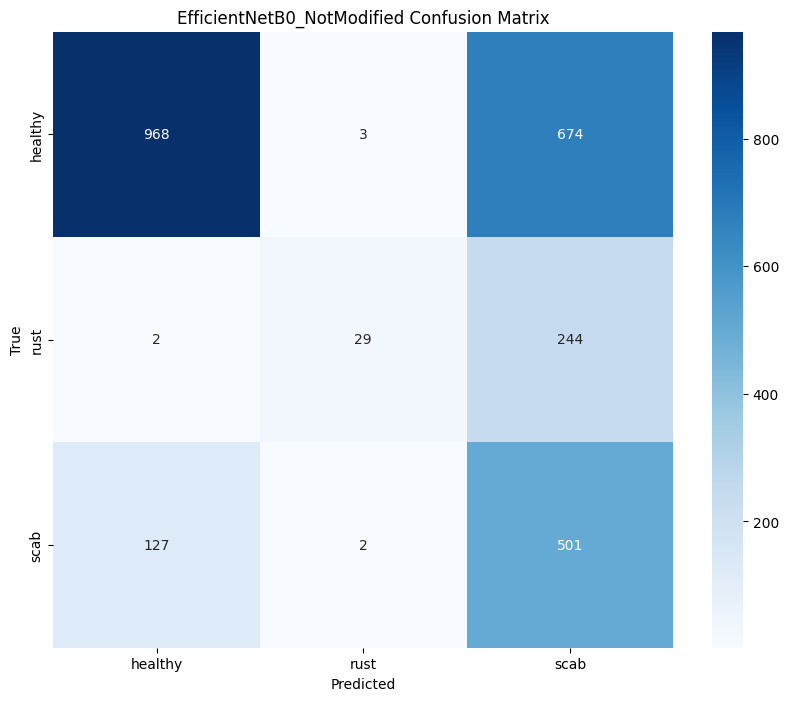

In [12]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(224, 224),
    batch_size=16,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 25
train_and_plot(model, "EfficientNetB0_NotModified", train_generator, validation_generator, test_generator, epochs =  epochs)

In [13]:
model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
model.trainable = True

# Freeze 50% layer pertama dari base model
total_layers = len(model.layers)
freeze_layers = int(0.50 * total_layers)
for layer in model.layers[:freeze_layers]:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 100s 641ms/step - accuracy: 0.3196 - loss: 1.6687 - val_accuracy: 0.4339 - val_loss: 1.0649
Epoch 2/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - accuracy: 0.4523 - loss: 1.3630 - val_accuracy: 0.4856 - val_loss: 0.9965
Epoch 3/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 289ms/step - accuracy: 0.4826 - loss: 1.2405 - val_accuracy: 0.5661 - val_loss: 0.8999
Epoch 4/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.5103 - loss: 1.1727 - val_accuracy: 0.6437 - val_loss: 0.8121
Epoch 5/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.5638 - loss: 1.0652 - val_accuracy: 0.6753 - val_loss: 0.7508
Epoch 6/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 275ms/step - accuracy: 0.5669 - loss: 1.0052 - val_accuracy: 0.7098 - val_loss: 0.6822
Epoch 7/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.6660 - loss: 0.8715 - val_accuracy: 0.7385 - val_loss: 0.6211
Epoch 8/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step - accuracy: 0.6688 - loss: 0.8582 - val_acc

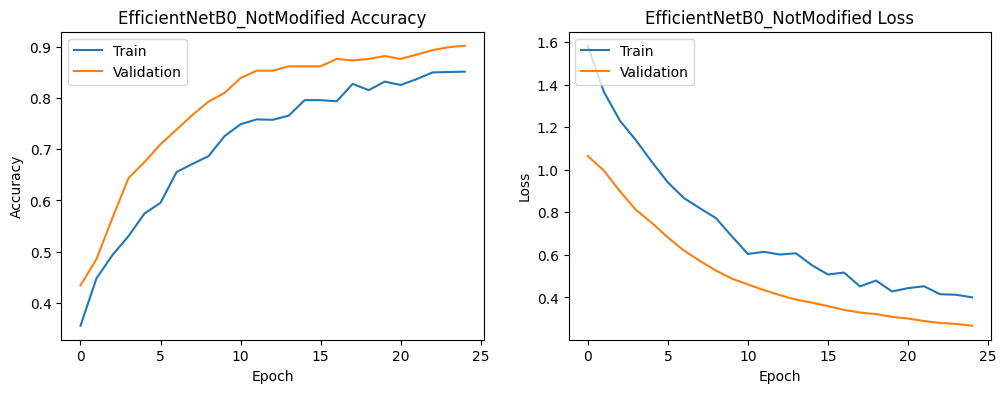

160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.8957 - loss: 0.3315
Test Accuracy: 0.7635
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.84      0.93      0.88      1645
        rust       0.64      0.36      0.46       275
        scab       0.55      0.50      0.52       630

    accuracy                           0.76      2550
   macro avg       0.68      0.60      0.62      2550
weighted avg       0.75      0.76      0.75      2550



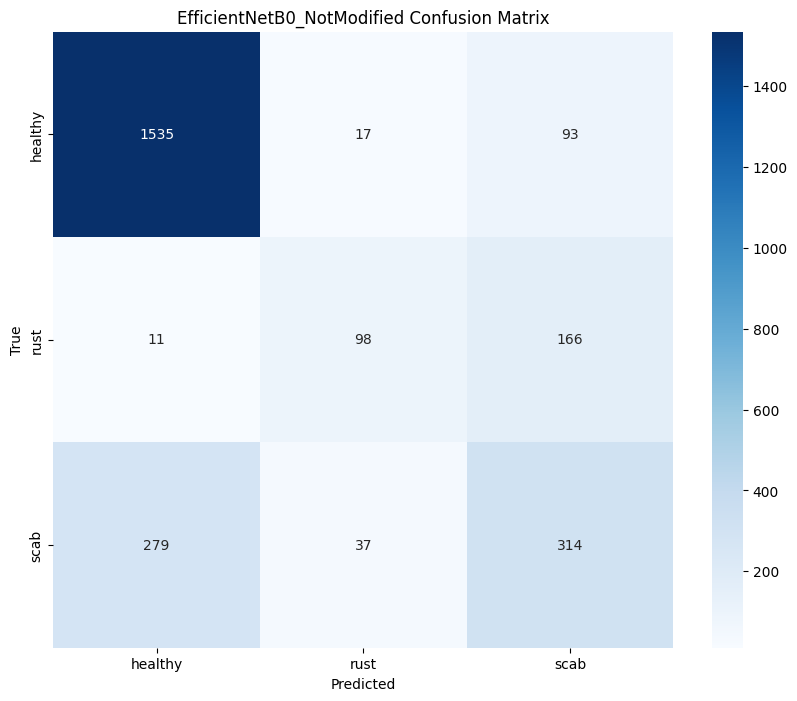

In [14]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(224, 224),
    batch_size=16,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 25
train_and_plot(model, "EfficientNetB0_NotModified", train_generator, validation_generator, test_generator, epochs =  epochs)

### B7 RTX 4090

In [10]:
model = EfficientNetB7(input_shape=(600, 600, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(600, 600, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 600, 600, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 19, 19, 2560)   │    53,618,519 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,319,194 (207.21 MB)

 Trainable params: 54,062,483 (206.23 MB)

 Non-trainable params: 256,711 (1002.78 KB)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.3037 - loss: 1.6199 - val_accuracy: 0.3420 - val_loss: 1.4662
Epoch 2/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 92s 528ms/step - accuracy: 0.3418 - loss: 1.4300 - val_accuracy: 0.3420 - val_loss: 1.6476
Epoch 3/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 152s 878ms/step - accuracy: 0.3572 - loss: 1.4127 - val_accuracy: 0.3420 - val_loss: 1.6766
Epoch 4/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 141s 814ms/step - accuracy: 0.3295 - loss: 1.5060 - val_accuracy: 0.3707 - val_loss: 2.8117
Epoch 5/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 90s 518ms/step - accuracy: 0.3423 - loss: 1.3977 - val_accuracy: 0.3678 - val_loss: 9.6644
Epoch 6/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 91s 524ms/step - accuracy: 0.3493 - loss: 1.3777 - val_accuracy: 0.3879 - val_loss: 16.2614
Epoch 7/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 94s 540ms/step - accuracy: 0.3736 - loss: 1.3454 - val_accuracy: 0.3736 - val_loss: 24.6332
Epoch 8/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 90s 517ms/step - accuracy: 0.3793 - loss:

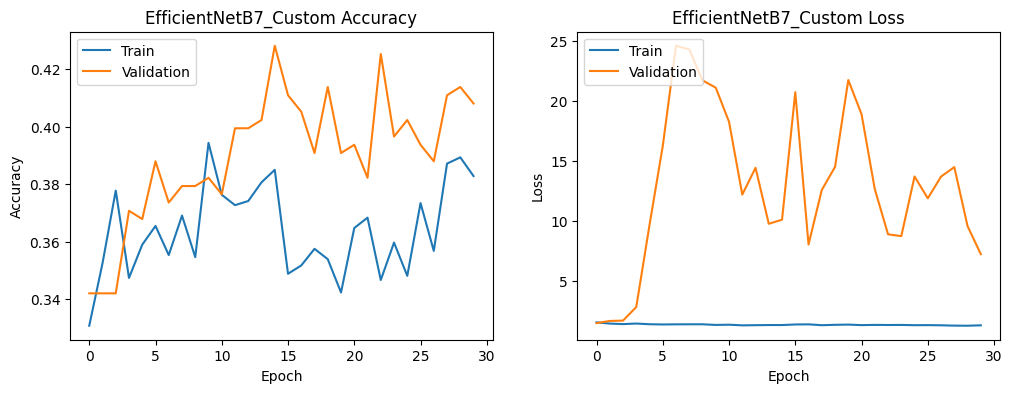

319/319 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - accuracy: 0.1438 - loss: 29.4541
Test Accuracy: 0.2439
319/319 ━━━━━━━━━━━━━━━━━━━━ 50s 115ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.74      0.13      0.22      1645
        rust       0.00      0.00      0.00       275
        scab       0.24      0.66      0.35       630

    accuracy                           0.24      2550
   macro avg       0.33      0.26      0.19      2550
weighted avg       0.54      0.24      0.23      2550



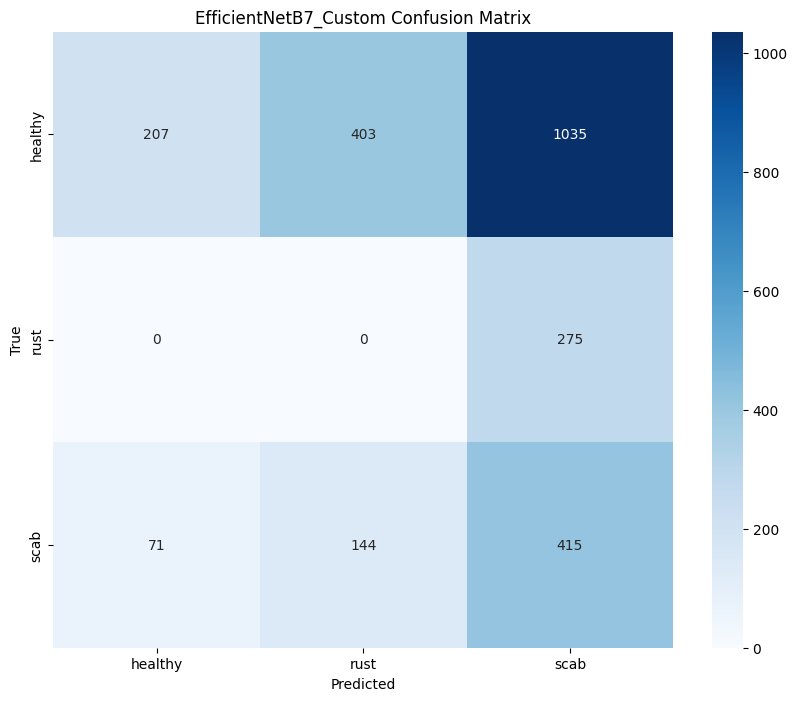

In [11]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(600, 600),
    batch_size=8,
    preprocess_input_func = efficientnet_preprocess
)

history_EN_B7, test_loss, test_acc, training_duration = train_and_plot(model, "EfficientNetB7_Custom", train_generator, validation_generator, test_generator, 30)

### B7 RTX A40

In [20]:
model = EfficientNetB7(input_shape=(600, 600, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(600, 600, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 600, 600, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 19, 19, 2560)   │    57,222,263 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,922,938 (220.96 MB)

 Trainable params: 57,636,275 (219.86 MB)

 Non-trainable params: 286,663 (1.09 MB)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1729352052.189204    3395 service.cc:146] XLA service 0x71629c014390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729352052.189269    3395 service.cc:154]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-10-19 15:34:15.290693: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-19 15:34:24.340277: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8905
E0000 00:00:1729352088.393029    3395 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729352088.584163    3395 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1

135/173 ━━━━━━━━━━━━━━━━━━━━ 22s 584ms/step - accuracy: 0.3291 - loss: 1.4415

E0000 00:00:1729352341.561859    3393 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729352341.738734    3393 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729352342.603626    3393 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729352342.750182    3393 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729352343.642149    3393 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

173/173 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - accuracy: 0.3310 - loss: 1.4393 - val_accuracy: 0.2989 - val_loss: 1.2354
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 111s 639ms/step - accuracy: 0.3477 - loss: 1.4143 - val_accuracy: 0.3420 - val_loss: 1.2928
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 98s 561ms/step - accuracy: 0.3676 - loss: 1.3640 - val_accuracy: 0.3448 - val_loss: 1.4572
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 104s 599ms/step - accuracy: 0.3927 - loss: 1.3141 - val_accuracy: 0.3994 - val_loss: 11.2917
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 91s 525ms/step - accuracy: 0.3979 - loss: 1.3161 - val_accuracy: 0.3966 - val_loss: 52.8341
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 89s 513ms/step - accuracy: 0.3597 - loss: 1.3155 - val_accuracy: 0.4052 - val_loss: 54.0727
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 99s 568ms/step - accuracy: 0.3708 - loss: 1.3159 - val_accuracy: 0.3879 - val_loss: 60.1369
Epoch 8/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 96s 553ms/step - accuracy: 0.3663 - loss: 1.3408 -

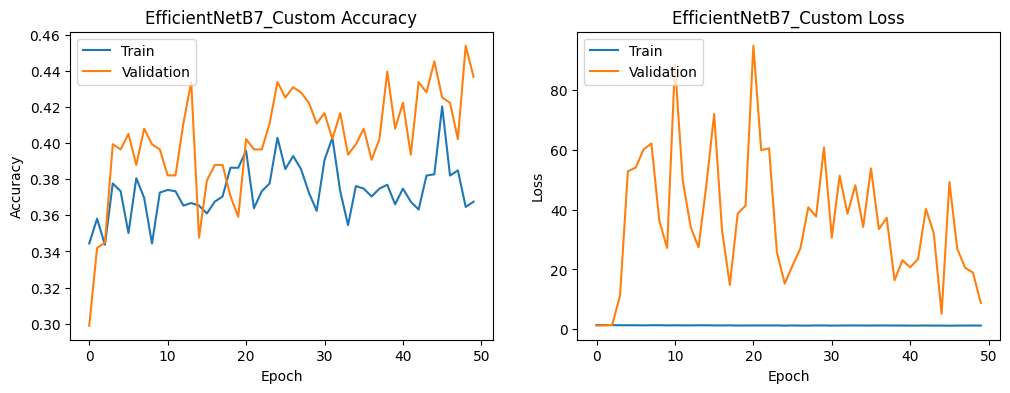

319/319 ━━━━━━━━━━━━━━━━━━━━ 51s 160ms/step - accuracy: 0.3766 - loss: 50.5613
Test Accuracy: 0.3792
319/319 ━━━━━━━━━━━━━━━━━━━━ 72s 168ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.77      0.40      0.53      1645
        rust       0.00      0.00      0.00       275
        scab       0.27      0.49      0.35       630

    accuracy                           0.38      2550
   macro avg       0.35      0.30      0.29      2550
weighted avg       0.56      0.38      0.43      2550



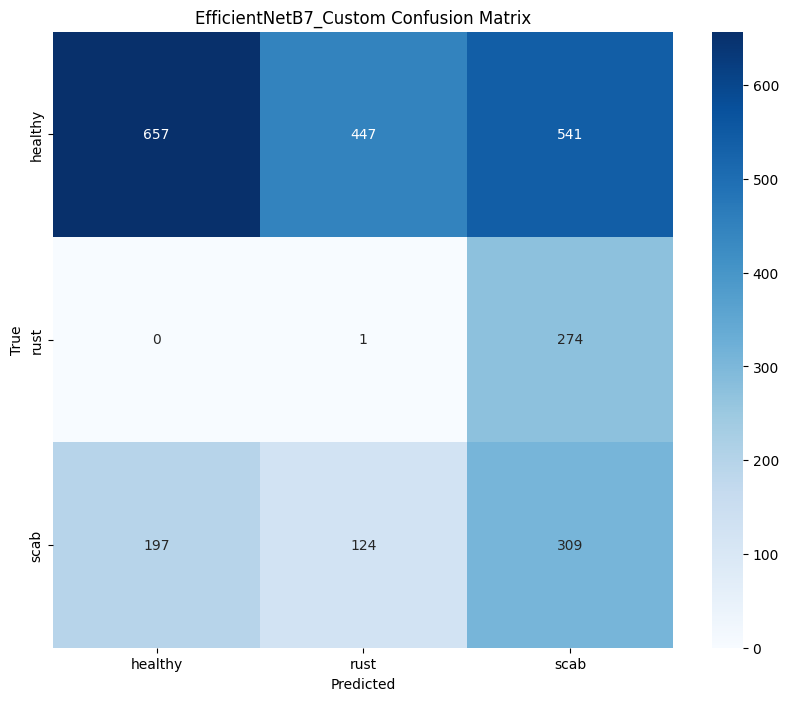

In [21]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(600, 600),
    batch_size=8,
    preprocess_input_func = efficientnet_preprocess
)

history_EN_B7, test_loss, test_acc, training_duration = train_and_plot(model, "EfficientNetB7_Custom", train_generator, validation_generator, test_generator, 50)